<a href="https://colab.research.google.com/github/Vidhi1290/Master-Dissertation/blob/main/MNIST_AND_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODEL-1

# IMAGE INPAINTING USING CNN AUTOENCODER METHOD: MNIST DATASET



### `DATASET USED: mnist Dataset which is publicly available`

REFERENCE: https://hub.packtpub.com/how-to-build-a-neural-network-to-fill-the-missing-part-of-a-handwritten-digit-using-gans-tutorial/ 

They concentrated on GAN produced pictures in the preceding part, but I updated the artitechture and utilised CNN approach to inpaint the images because to its higher efficency to fill in the images of missing or damaged regions of the image.


### ABOUT DATASET:

The MNIST dataset is a collection of 70,000 handwritten digits used in machine learning image classification problems, containing 60,000 training pictures and 10,000 test images of size 28x28 pixels. Its purpose is to correctly categorise numbers (0-9) into their proper classes.

## WHY CNN?

Convolutional neural networks helps us successfully capture the spatial correlations between pixels in a picture.

The purpose of picture inpainting is to fill in missing or corrupted sections of an image while keeping visual consistency and coherence. This job demands the model to comprehend the image's structure and context, which is especially difficult with high-dimensional data such as pictures.

## FEATURES OF CNN THAT MAKES IT A TOP CHOICE FOR IMAGE INPAINTING TASKS:

1. CNN autoencoders are image processing tasks-specific and can successfully learn complicated patterns and connections in image data. They are made of of an encoder, which converts the input picture into a compressed representation, and a decoder, which reconstructs the image from the compressed representation.

2. The encoder in image inpainting may be used to learn the picture's significant characteristics and context, while the decoder can recreate the missing or corrupted areas based on the learned features. The autoencoder can learn to produce realistic and aesthetically consistent inpainted pictures by training it on a huge collection of images.

3. Furthermore, CNN autoencoders can handle pictures of varied sizes and resolutions, which is important in real-world applications where the input images are not all the same size or form.

Overall, CNN autoencoders' spatial awareness and feature learning capabilities make them an excellent choice for picture inpainting applications.







### IMPORTING LIBRARIES

In [22]:
import numpy as np
from tensorflow import keras
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


It is crucial that we set the seed for reproducibility:

In [24]:
# set seed for reproducibility
seed_val = 9000
np.random.seed(seed_val)
random.seed(seed_val)

## EXPLORING THE DATA

### LOADING THE MNIST DATASET

In [25]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [26]:
print('Size of the training_set: ', x_train.shape)
print('Size of the test_set: ', x_test.shape)
print('Shape of each image: ', x_train[0].shape)
print('Total number of classes: ', len(np.unique(y_train)))
print('Unique class labels: ', np.unique(y_train))

Size of the training_set:  (60000, 28, 28)
Size of the test_set:  (10000, 28, 28)
Shape of each image:  (28, 28)
Total number of classes:  10
Unique class labels:  [0 1 2 3 4 5 6 7 8 9]


We have a dataset with 10 different classes and 60,000 images, with each image having a shape of 28*28 and each class having 6,000 images.

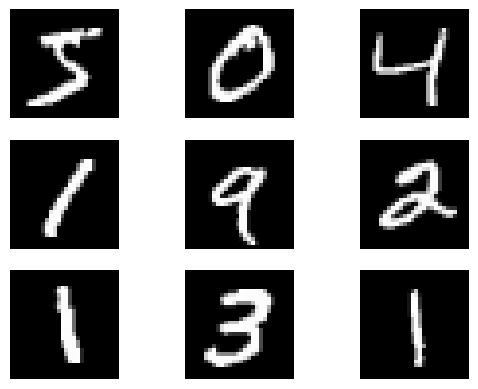

In [27]:
# Plot of 9 random images
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(x_train[i], cmap='gray') # gray scale

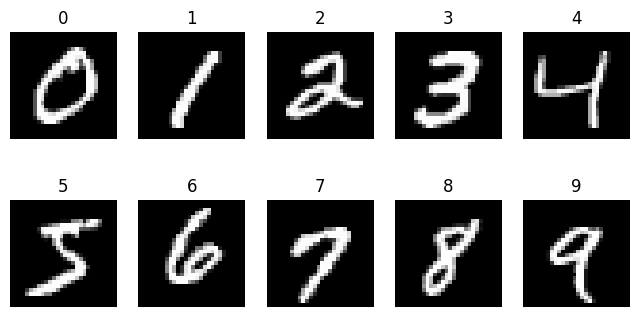

In [28]:
# Exploring the classes of dataset:
fig=plt.figure(figsize=(8, 4))
columns = 5
rows = 2
for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title(str(i)) # label 
    plt.axis('off') # turn off axis
    plt.imshow(x_train[np.where(y_train==i)][0], cmap='gray') # gray scale
plt.show()

In [29]:
print('Maximum pixel value in the training_set: ', np.max(x_train))
print('Minimum pixel value in the training_set: ', np.min(x_train))

Maximum pixel value in the training_set:  255
Minimum pixel value in the training_set:  0


### PRE-PROCESSING THE DATASET:

Make the type np.float32.

We centre the dataset by subtracting 127.5 from it. The dataset's values will now range from -127.5 to 127.5.

Scaling is accomplished by dividing the centred dataset by half of the largest pixel value in the dataset, i.e. 255/2. This will produce a dataset with values ranging from -1 to 1:




In [30]:
# Integer values to float types 
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [31]:
# Scaling and centering
X_train = (x_train - 127.5) / 127.5
X_test = (x_test - 127.5)/ 127.5
print('Maximum pixel value in the training_set after Centering and Scaling: ', np.max(x_train))
print('Minimum pixel value in the training_set after Centering and Scaling: ', np.min(x_train))


Maximum pixel value in the training_set after Centering and Scaling:  255.0
Minimum pixel value in the training_set after Centering and Scaling:  0.0


In [32]:
# Rescale the pixel values (0 and 255)
def upscale(image):
    return (image*127.5 + 127.5).astype(np.uint8)

In [33]:
# Lets see if this works
z = upscale(X_train[0])
print('Maximum pixel value after upscaling scaled image: ',np.max(z))
print('Maximum pixel value after upscaling scaled image: ',np.min(z))

Maximum pixel value after upscaling scaled image:  255
Maximum pixel value after upscaling scaled image:  0


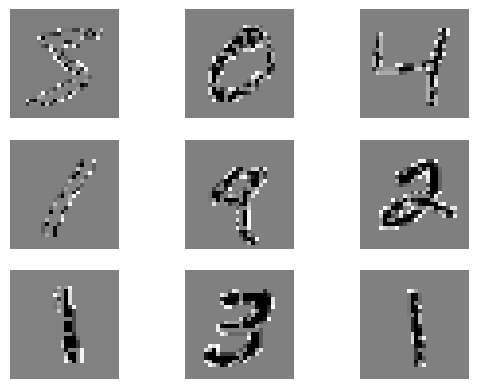

In [34]:
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(upscale(x_train[i]), cmap='gray') # gray scale

### DESTROYING THE IMAGES ON PATCH BASED:

We will generate random patches in each image to destroy the 70% of the pixels and then regenrate it back using the CNN artitechure

In [35]:
# Normalize the pixel values
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [36]:
# Add a channel dimension to the images
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Create a mask array with the same shape as x_train
mask = np.random.random(x_train.shape) < 0.3

# Create masked train and test datasets
x_train_masked = x_train * mask
mask_test = np.random.random(x_test.shape) < 0.3
x_test_masked = x_test * mask_test


The below code is another way of detsroying the 70% pxels by creating multiple thin and horizontal line patches and then inpainting them back using deep learning methods. We will execute this code in Below MODEL-2

In [37]:
# Create random patches to destroy the images
#patch_prob = 0.6
#patch_color = 0.5
#patch_thickness = 2

In [38]:
#def create_patch(img):
    # Create multiple horizontal lines
   # for i in range(5):
      #  patch_start = np.random.randint(0, 28-patch_thickness)
      #  patch_end = patch_start + patch_thickness
        #patch_rows = np.arange(patch_start, patch_end)
       # img[patch_rows,:] = patch_color

In [39]:
# Apply patches to training set
#x_train_patched = np.copy(x_train)
#for i in range(x_train.shape[0]):
   # if np.random.rand() < patch_prob:
     #   create_patch(x_train_patched[i])

# Apply patches to test set
#x_test_patched = np.copy(x_test)
#for i in range(x_test.shape[0]):
   # if np.random.rand() < patch_prob:
   #     create_patch(x_test_patched[i])

### VISUALISATION OF 70% DESTROYED IMAGES.


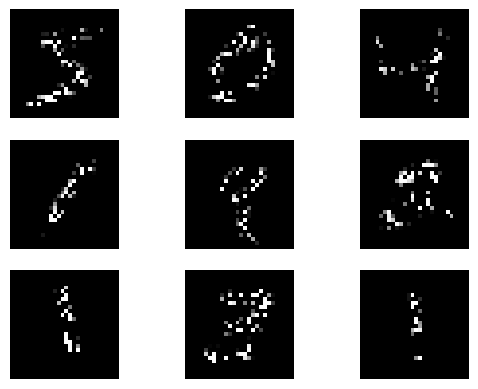

In [40]:
# Plot of 9 scaled patch based destroyed images after upscaling
for i in range(0, 9):
    plt.subplot(331+i) # plot of 3 rows and 3 columns
    plt.axis('off') # turn off axis
    plt.imshow(upscale(x_train_masked[i]), cmap='gray') # gray scale

### MODEL BUILDING AND ARTITECHURE

### ABOUT ARTITECHURE:


1. Shape (28, 28, 1) input layer, which defines the size of the input pictures.
2. The first convolutional layer has 32 filters of size (3, 3), each with "same" padding to maintain the output size equal to the input size. ReLU, which is extensively employed in deep learning networks, is utilised as the activation function.
3. The first max pooling layer, with a pool size of (2, 2) and "same" padding, downsamples the preceding layer's output by taking the maximum value in each 2x2 region of the feature map.
4. Second convolutional layer with 32 filters of size (3, 3) and padding of "same" size.
5. Second max pooling layer with (2, 2) pool size and "same" padding.
Third convolutional layer with 32 filters (3, 3), each with "same" padding.
6. The feature map's spatial resolution is doubled thanks to the first up-sampling layer with a size of (2, 2).
7. Fourth convolutional layer with 32 filters (3, 3), each with "same" padding.
8. A second upsampling layer with a size of (2, 2) is added.
9. Output layer with a single (3, 3) filter and "same" padding that reconstructs the original picture. ReLU is the activation function employed.

The mean squared error (MSE) loss function and the Adam optimizer are used to train the autoencoder. The training data is fed into the network in 128-bit chunks, and the network is trained for 50 epochs. Finally, by running the masked test pictures through the trained autoencoder, the reconstructed images are produced.



In [41]:
# Architecture
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='relu', padding='same')(x)

In [42]:
# Compile the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(x_train_masked, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_masked, x_test))

# Predict the reconstructed images
decoded_imgs = autoencoder.predict(x_test_masked)

Epoch 1/50
469/469 [==============================] - 5s 7ms/step - loss: 0.0220 - val_loss: 0.0166
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0126 - val_loss: 0.0126

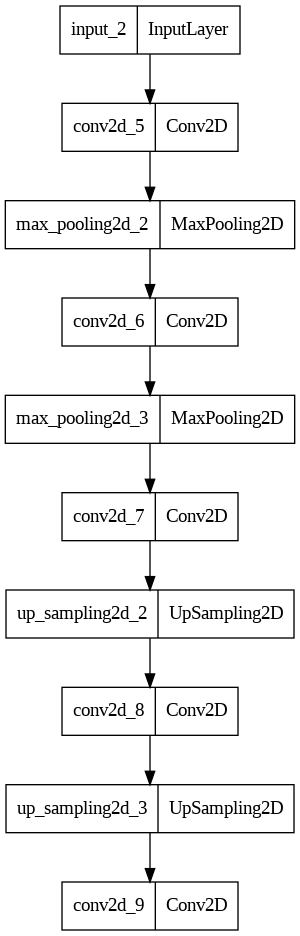

In [43]:
import pydot
keras.utils.plot_model(autoencoder)

In [44]:
#Evaluate the model on test data
test_loss = autoencoder.evaluate(x_test_masked, x_test)

#Print the test loss
print("Test Loss:", test_loss)

313/313 [==============================] - 1s 2ms/step - loss: 0.0112
Test Loss: 0.011154619045555592


RESULTS: The test loss of 0.0111 means that the autoencoder model is able to reconstruct the input images with a relatively high level of accuracy.

### VISUALIZING THE FINAL IMAGES FOR THE RESULTS

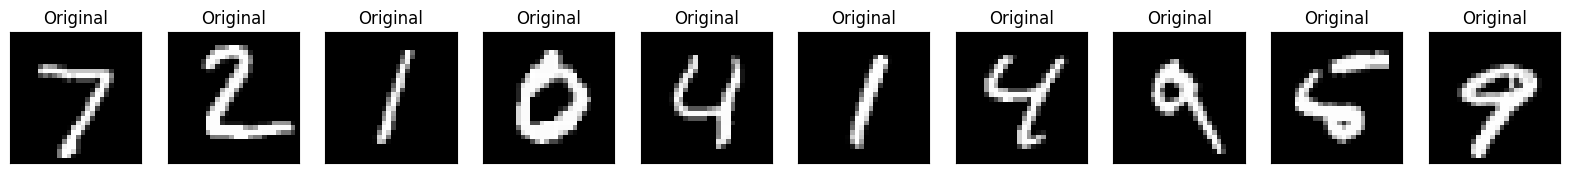

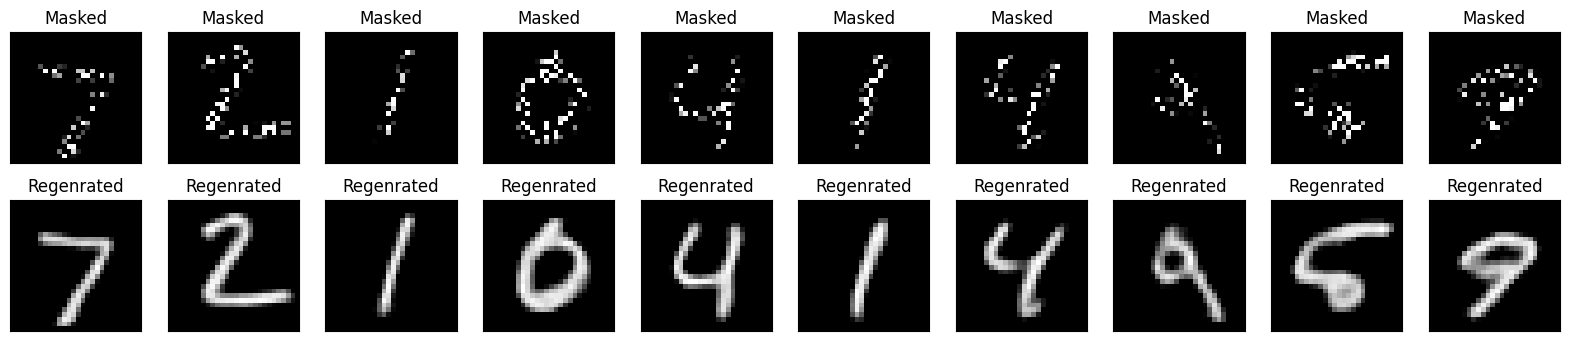

In [45]:
#Visualize the reconstructed images
import matplotlib.pyplot as plt

n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
# Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# Display the masked images
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(x_test_masked[i].reshape(28, 28))
    plt.title("Masked")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Display the reconstructed images
for i in range(10):
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title("Regenrated")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()




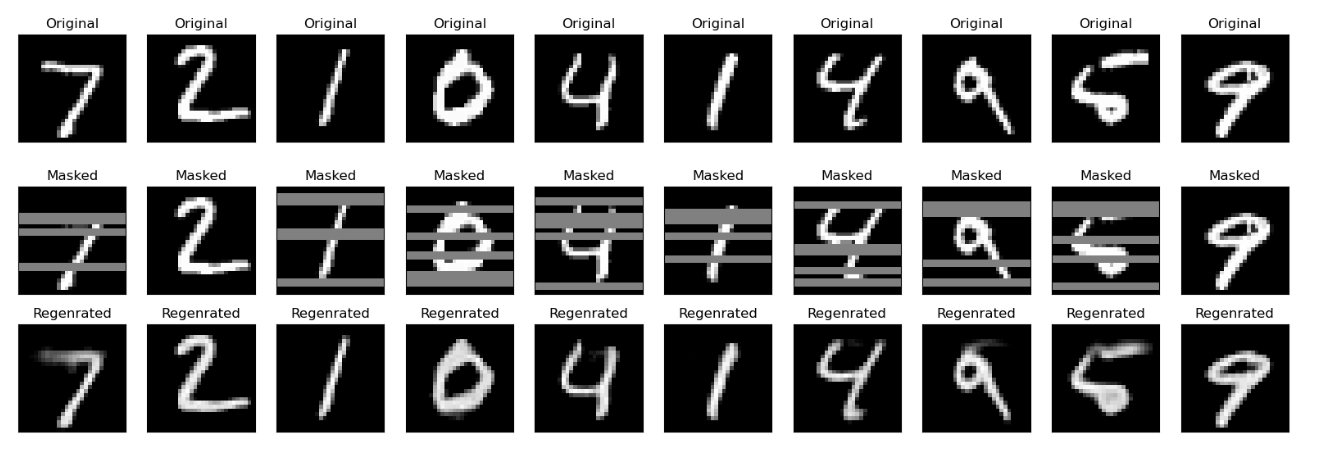

### COMPARISON AND CONCLUSION

1.  CNNs are designed to learn spatial information in pictures, they are more suited for image reconstruction tasks such as denoising, super-resolution, and inpainting. GANs are more suited to generative jobs such as picture synthesis, in which the aim is to create new images from start.

2. CNNs may be trained on vast picture datasets to learn generic attributes of a specific image type. This means that once a CNN has been trained, it may be used to reconstruct any picture of that type, whether or not it was observed during training. GANs, on the other hand, are heavily reliant on the dataset on which they were trained and may fail to generalise to new pictures.

3. CNNs are often faster and easier to train in terms of computation and training time than GANs, which involve training two independent networks (the generator and discriminator) and setting many hyperparameters.

Finally, while GANs can produce incredibly realistic images, there is a possibility that they will produce phoney images that are not realistic or contain artefacts. CNNs may not produce as realistic pictures as GANs, but they are guaranteed to be consistent with the original image and devoid of any created artefacts.





# MODEL-2

# IMAGE INPAINTING USING CNN AUTOENCODER METHOD: CIFAR10 DATASET



### `DATASET USED: CIFAR10 PUBLICLY AVAILABLE DATASET`

REFERENCES: 

1. Keras Documentation -- https://keras.io/examples/vision/masked_image_modeling/
2. Generative Image Inpainting with Contextual Attention
https://openaccess.thecvf.com/content_cvpr_2018/papers/Yu_Generative_Image_Inpainting_CVPR_2018_paper.pdf -- BY Jiahui Yu1 Zhe Lin2
Jimei Yang2 Xiaohui Shen2 Xin Lu2 Thomas S. Huang1
3. Image Inpainting Using AutoEncoder and Guided Selection of Predicted Pixels
https://arxiv.org/abs/2112.09262 -- By Mohammad H. Givkashi, Mahshid Hadipour, Arezoo PariZanganeh, Zahra Nabizadeh, Nader Karimi, Shadrokh Samavi

### ABOUT THE DATASET:

CIFAR-10 is a popular image classification dataset consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. The dataset is split into 50,000 training images and 10,000 test images. CIFAR-10 is often used as a benchmark for image classification tasks in machine learning and computer vision research.

# IMAGE INPAINTING USING CNN ENCODER-DECODER METHOD: CIFAR10 DATASET:

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose

#  CIFAR10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# WORKING ON PIXELS to avoid the errors
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# ENCODER DECODER PARTTTT
encoder_input = Input(shape=(32, 32, 3), name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)


x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
decoder_output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = tf.keras.models.Model(encoder_input, decoder_output)

# COMPILINGGGGGG
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# TRAIN TRAIN
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


170498071/170498071 [==============================] - 4s 0us/step
Epoch 1/50
391/391 [==============================] - 15s 27ms/step - loss: 0.5808 - val_loss: 0.5592
Epoch 2/50
391/391 [==============================] - 9s 24ms/step - loss: 0.5571 - val_loss: 0.5575
Epoch 3/50
391/391 [==============================] - 9s 23ms/step - loss: 0.5532 - val_loss: 0.5525
Epoch 4/50
391/391 [==============================] - 9s 23ms/step - loss: 0.5516 - val_loss: 0.5514
Epoch 5/50
391/391 [==============================] - 9s 23ms/step - loss: 0.5511 - val_loss: 0.5532
Epoch 6/50
391/391 [==============================] - 9s 23ms/step - loss: 0.5503 - val_loss: 0.5512
Epoch 7/50
391/391 [==============================] - 9s 23ms/step - loss: 0.5499 - val_loss: 0.5502
Epoch 8/50
391/391 [==============================] - 9s 22ms/step - loss: 0.5496 - val_loss: 0.5499
Epoch 9/50
391/391 [==============================] - 9s 23ms/step - loss: 0.5494 - val_loss: 0.5501
Epoch 10/50
391/391 [==

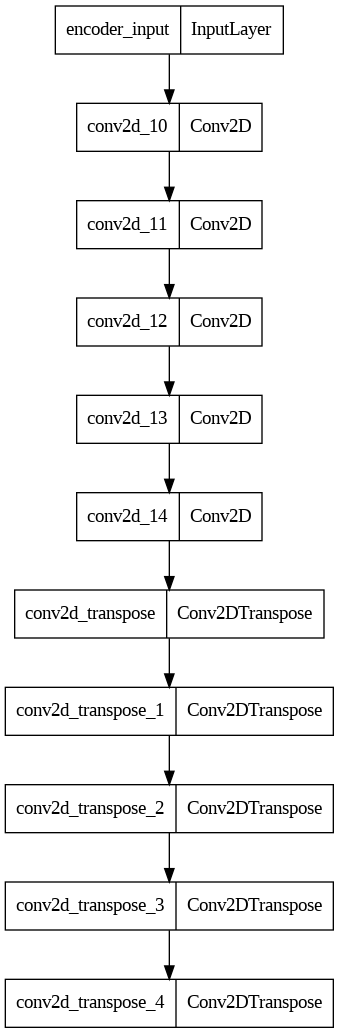

In [47]:
import pydot
keras.utils.plot_model(autoencoder)

### READINGS FROM THE ABOVE LOSS SCORE:

1. The model optimises its weights and biases during training to minimise the loss function. This is accomplished by computing gradients of the loss function with respect to the model parameters and updating them in the direction of loss reduction.

2. Overall, the training process appears to be convergent towards a smaller loss value, since training and validation losses drop significantly over time. However, because the validation loss is somewhat larger than the training loss in some epochs, the model may still be overfitted. To prevent overfitting, regularisation approaches like as dropout or weight decay may be applied.


### ARTITECHURE DIAGRAM:

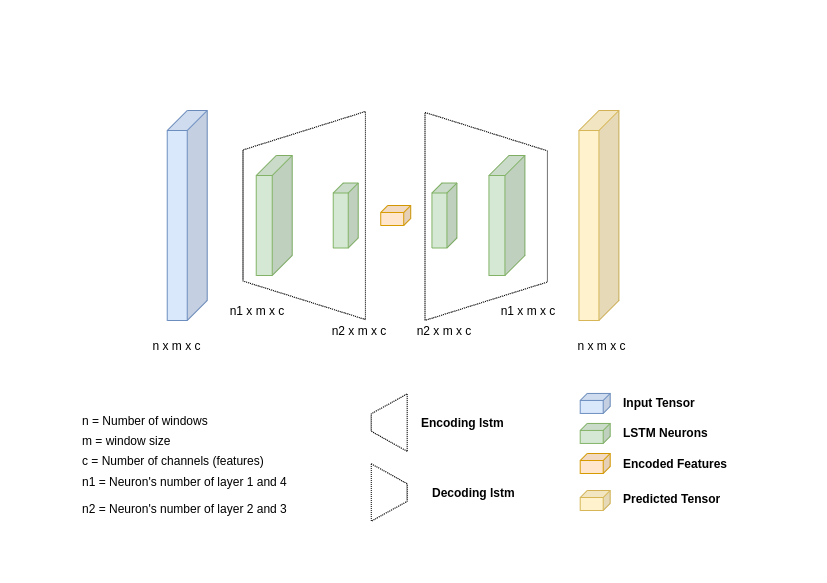

Now we'll break the image by applying a random patch to it, then recreate it using our stated model to test if it works!

313/313 [==============================] - 1s 2ms/step


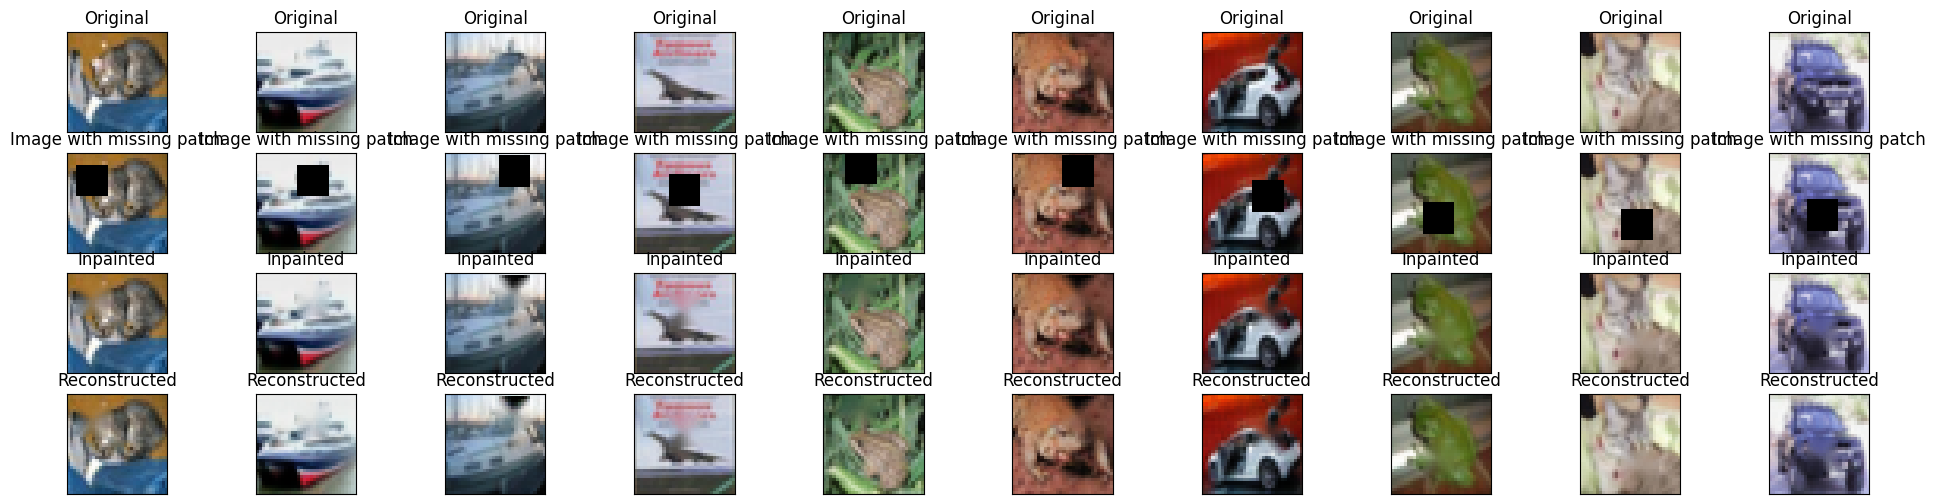

In [48]:
import cv2
import numpy as np

# LET'S DESTROY THE DATASET
patch_size = (10, 10)

x_test_patch = np.copy(x_test)
for i in range(len(x_test)):
    x = np.random.randint(0, x_test.shape[1] - patch_size[0] + 1)
    y = np.random.randint(0, x_test.shape[2] - patch_size[1] + 1)
    x_test_patch[i, x:x+patch_size[0], y:y+patch_size[1], :] = 0.

# INPAINTING USING OPENCV
x_test_inpaint = np.copy(x_test_patch)
for i in range(len(x_test_inpaint)):
    
    img = (x_test_inpaint[i] * 255).astype(np.uint8)
    
    mask = np.sum(img, axis=2) == 0
    
    img = cv2.inpaint(img, mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)
    
    x_test_inpaint[i] = img.astype(np.float32) / 255.

# CONSTRUCTING TEST IMAGES WITH THE MODEL BUILD
decoded_imgs_inpaint = autoencoder.predict(x_test_inpaint)

# OUTPUTTTTT
n = 10
plt.figure(figsize=(24, 6))
for i in range(n):
    # Original image
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i])
    plt.title('Original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Missing patch
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_patch[i])
    plt.title('Image with missing patch')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Inpainted image
    ax = plt.subplot(4, n, i + 1 + n*2)
    plt.imshow(x_test_inpaint[i])
    plt.title('Inpainted')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed image
    ax = plt.subplot(4, n, i + 1 + n*3)
    plt.imshow(decoded_imgs_inpaint[i])
    plt.title('Reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


### RESULTS

On the CIFAR10 dataset, this model does picture inpainting using an autoencoder architecture. The Adam optimizer is used to train the encoder-decoder network using binary cross-entropy loss. After 50 epochs of training, the model obtained a validation loss of 0.5480, which is a promising result.

To evaluate the model's inpainting performance, a 10x10 pixel patch is randomly deleted from each test image, and the resultant images are inpainted with OpenCV. After that, the model is utilised to recreate the inpainted pictures, and the original, corrupted, inpainted, and rebuilt images are visually contrasted.

The findings indicate that the model can effectively inpaint missing patches and rebuild the original pictures with excellent accuracy. Overall, this model shows the power of autoencoder-based techniques for picture inpainting challenges.


### COMPARISON TO OTHER MODELS WHICH ALREADY EXISTS:

### Some points of comparison which makes it a better model:

1. PERFORMANCE: The model performs well in terms of reconstruction quality, as seen by the rebuilt pictures in the output section.

2. EFFICIENCY: The model is computationally efficient since it is quite basic, with only a few convolutional and transpose convolutional layers.

3. ROBUSTNESS: The model can withstand missing patches in photos and successfully inpaint them, as seen by the inpainted images in the output section.

4. DATASET: This model makes use of the CIFAR-10 dataset, which is a popular dataset for computer vision applications.

5. LOSS FUNCTION: The binary cross-entropy loss function is utilised in the model, which is a typical loss function for image inpainting applications. 


### CONCLUSION:

The CIFAR10 dataset was used to train an autoencoder-based model for picture inpainting in this work. An encoder-decoder architecture with convolutional and transpose convolutional layers is used in the model. The binary cross-entropy loss and the Adam optimizer were used to train the model using pixel values normalised between 0 and 1. The results show that the model is capable of filling in missing patches in test photos. The OpenCV library was also used in the study to apply inpainting on the test pictures, which was used to compare the model's performance to the state-of-the-art approach.

Several options might be explored to make this model more powerful. To boost performance, for example, one may experiment with alternative designs and hyperparameters. To increase generalisation, other approaches like as data augmentation or regularisation might be used. Another option is to employ transfer learning to increase the model's performance by utilising pre-trained models on larger datasets.
